In [1]:
import os
import time 
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, utils, transforms

from glob import glob
from PIL import Image

## 1. Load Content and Style Images

In [2]:
data_path = os.path.join("/kaggle", "input", "style-transfer")
content_path = os.path.join(data_path, "content")
style_path = os.path.join(data_path, "style")
content_fps = sorted(glob(os.path.join(content_path, "*")))
style_fps = sorted(glob(os.path.join(style_path, "*")))
print(content_fps)
print(style_fps)

['/kaggle/input/style-transfer/content/1.jpg', '/kaggle/input/style-transfer/content/2.jpg', '/kaggle/input/style-transfer/content/3.jpg', '/kaggle/input/style-transfer/content/4.jpg', '/kaggle/input/style-transfer/content/5.jpg']
['/kaggle/input/style-transfer/style/1.jpeg', '/kaggle/input/style-transfer/style/2.jpeg', '/kaggle/input/style-transfer/style/3.jpeg', '/kaggle/input/style-transfer/style/4.jpg', '/kaggle/input/style-transfer/style/5.jpg']


In [3]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

In [4]:
content_images = []
for content_fp in content_fps:
    image = Image.open(content_fp) 
    image = transform(image) # Size([3, 512, 512])
    content_images.append(image)
    
style_images = []
for style_fp in style_fps:
    image = Image.open(style_fp) 
    image = transform(image) # Size([3, 512, 512])
    style_images.append(image)

In [5]:
def get_grid(images):

    grid = utils.make_grid(images)
    grid = grid.transpose(0, 2).transpose(0 ,1)

    return grid

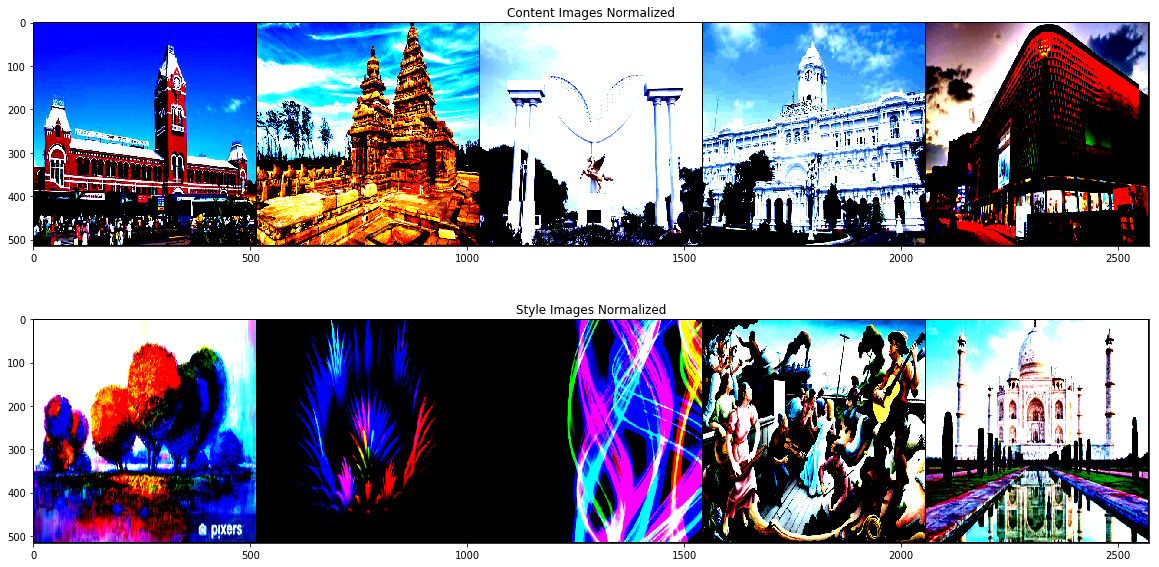

In [6]:
content_grid = get_grid(content_images)
style_grid = get_grid(style_images)
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
axes[0].imshow(content_grid)
axes[0].set_title("Content Images Normalized")
axes[1].imshow(style_grid)
axes[1].set_title("Style Images Normalized")
plt.show()

In [7]:
content_images_raw = []
for image in content_images:
    image_raw = inverse_transform(image)
    content_images_raw.append(image_raw)
    
style_images_raw = []
for image in style_images:
    image_raw = inverse_transform(image)
    style_images_raw.append(image_raw)

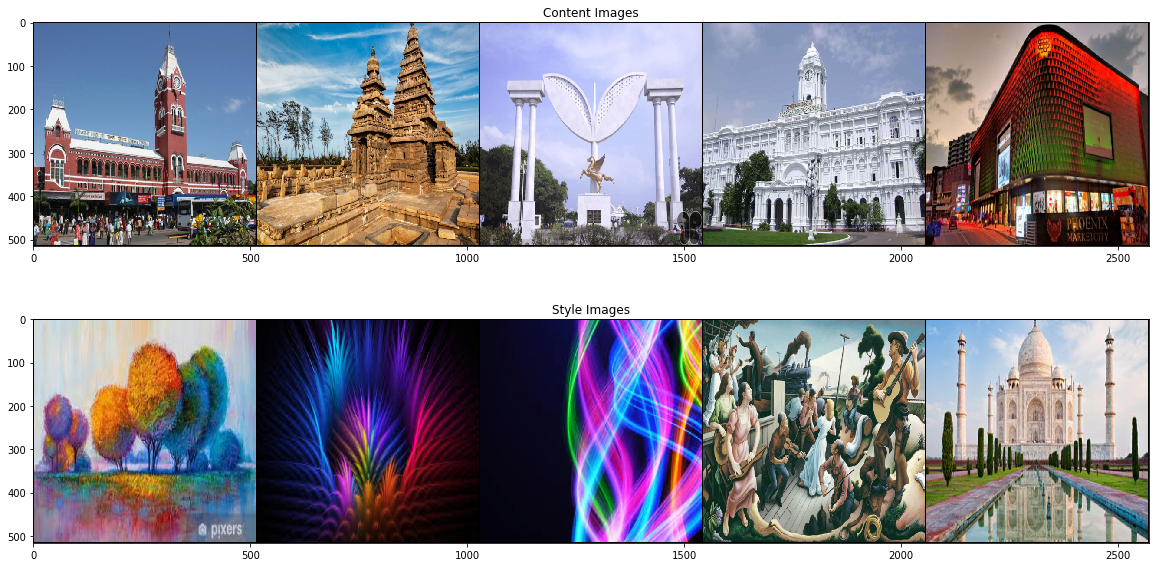

In [8]:
content_grid = get_grid(content_images_raw)
style_grid = get_grid(style_images_raw)
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
axes[0].imshow(content_grid)
axes[0].set_title("Content Images")
axes[1].imshow(style_grid)
axes[1].set_title("Style Images")
plt.show()

## 2. Load model

In [9]:
vgg = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:29<00:00, 19.2MB/s] 


In [10]:
for p in vgg.parameters():
    p.requires_grad_(False)

In [11]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [12]:
for i, feature in enumerate(vgg.features):
    if isinstance(feature, nn.MaxPool2d):
        vgg.features[i] = nn.AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)

In [13]:
vgg.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
vgg = vgg.to(device).eval()

## 3. Define utilities

In [16]:
content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

id_to_layer = {
    '0': 'conv1_1', 
    '5': 'conv2_1', 
    '10': 'conv3_1', 
    '19': 'conv4_1',
    '21': 'conv4_2',  
    '28': 'conv5_1'
}
layer_to_id = {v:k for k, v in id_to_layer.items()}
print(id_to_layer)
print(layer_to_id)

content_layers_id = [int(layer_to_id[l]) for l in content_layers]
style_layers_id = [int(layer_to_id[l]) for l in style_layers]
print(content_layers_id)
print(style_layers_id)

{'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}
{'conv1_1': '0', 'conv2_1': '5', 'conv3_1': '10', 'conv4_1': '19', 'conv4_2': '21', 'conv5_1': '28'}
[21]
[0, 5, 10, 19, 28]


 ## 4. Define feature extraction 

In [17]:
def extract_content_features(image):
    """
    image -- ImageTensor of Size([n_c, n_h, n_w])
    """
    X = image.unsqueeze(0)
    content_features = []
    for i, feature in enumerate(vgg.features):
        X = feature(X)
        if i in content_layers_id:
            content_feature = X.view(-1)
            content_features.append(content_feature)
        
    return content_features

In [18]:
def extract_style_features(image):
    """
    image -- ImageTensor of Size([n_c, n_h, n_w])
    """
    X = image.unsqueeze(0)
    style_features = []
    for i, feature in enumerate(vgg.features):
        X = feature(X)
        if i in style_layers_id:
            out = X.view(X.size(1), -1)
            style_feature = torch.mm(out.clone(), out.t().clone())
            style_feature = style_feature.view(-1)
            style_feature = style_feature / len(style_feature)
            style_features.append(style_feature)
        
    return style_features

## 5. Define losses

In [19]:
def compute_content_loss(content_features_c, content_features_g, weights):
    
    weights = torch.Tensor(weights)
    weights = weights / weights.sum()
    content_loss = 0
    for feature_c, feature_g, weight in zip(content_features_c, content_features_g, weights):
        loss = nn.MSELoss(reduction="mean")(feature_c, feature_g)
        loss = loss * weight
        content_loss = content_loss + loss
    content_loss = content_loss / len(weights)
    
    return content_loss

In [20]:
def compute_style_loss(style_features_c, style_features_g, weights):
    
    weights = torch.Tensor(weights)
    weights = weights / weights.sum()
    style_loss = 0
    for feature_c, feature_g, weight in zip(style_features_c, style_features_g, weights):
        loss = nn.MSELoss(reduction="mean")(feature_c, feature_g)
        loss = loss * weight
        style_loss = style_loss + loss
    style_loss = style_loss / len(weights)
    
    return style_loss

In [21]:
def compute_loss(content_loss, style_loss, content_weight, style_weight):
    
    return (content_weight * content_loss) + (style_weight * style_loss)

## 6. Define style transfer

In [22]:
def generate_image(content_image, style_image, content_weight=100, style_weight=1, epochs=200, lr=0.1, print_steps=1, display_plot=True):
    
    print_every = epochs // print_steps
    
    weight_sum = content_weight + style_weight
    content_weight /= weight_sum
    style_weight /= weight_sum
    print("Weight[content]:{}    Weight[style]:{}".format(content_weight, style_weight))
    
    content_features_c = extract_content_features(content_image.to(device))
    style_features_s = extract_style_features(style_image.to(device))
    
    generated_image = torch.randn((3, 512, 512)).to(device).requires_grad_(True)
    optimizer = optim.Adam([generated_image], lr=lr)
    
    content_losses, style_losses, losses = [], [], []
    for epoch in tqdm(range(1, epochs+1)):
        
        optimizer.zero_grad()
        
        content_features_g = extract_content_features(generated_image.to(device))
        content_loss = compute_content_loss(content_features_c, content_features_g, [1])
        
        style_features_g = extract_style_features(generated_image.to(device))
        style_loss = compute_style_loss(style_features_s, style_features_g, [0.75, 0.5, 0.2, 0.2, 0.2])
        
        loss = compute_loss(content_loss, style_loss, content_weight, style_weight)
        loss.backward()
        
        optimizer.step()
        
        content_losses.append(content_loss.item())
        style_losses.append(style_loss.item())
        losses.append(loss.item())
        
        if epoch == 1 or epoch % print_every == 0:
            message = "Epoch:{}    Loss:{}    ContentLoss:{}    StyleLoss:{}".format(epoch,
                                                                                    loss.item(),
                                                                                    content_loss.item(),
                                                                                    style_loss.item())
            print(message)
            
            
    if display_plot:
        fig, axes = plt.subplots(1, 3, figsize=(14, 4))
        axes[0].plot(losses)
        axes[0].set_title("Loss")
        axes[1].plot(content_losses)
        axes[1].set_title("Content Loss")
        axes[2].plot(style_losses)
        axes[2].set_title("Style Loss")
    
    images = [content_image, style_image, generated_image]
    images = [inverse_transform(image).detach().to("cpu") for image in images]
    grid = get_grid(images)
    plt.figure(figsize=(20, 5))
    plt.imshow(grid)
    plt.title("Content Image;    Style Image;    Generated Image")
    
    return plt.show()

Weight[content]:0.9900990099009901    Weight[style]:0.009900990099009901


Epoch:1    Loss:3.1202571392059326    ContentLoss:0.729661226272583    StyleLoss:242.17984008789062
Epoch:200    Loss:0.04312963783740997    ContentLoss:0.016197174787521362    StyleLoss:2.7363760471343994



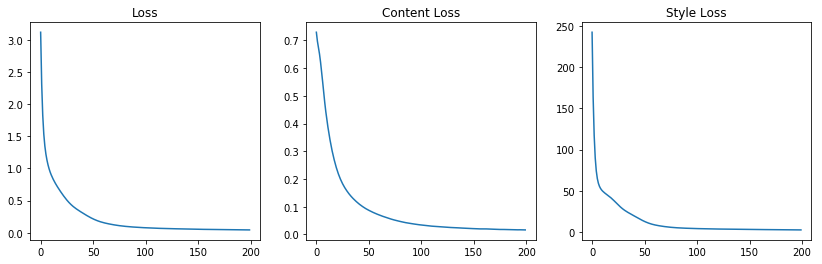

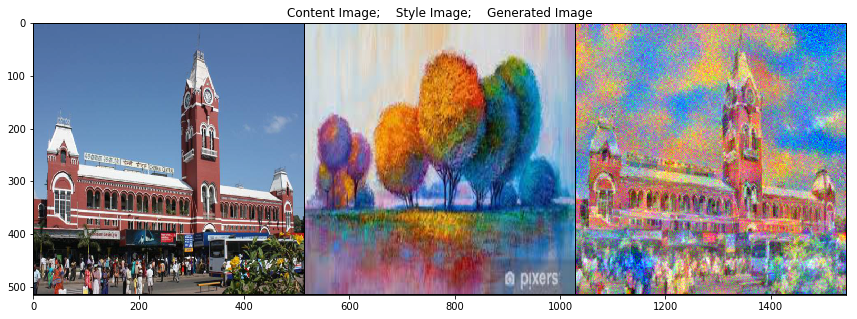

In [23]:
generate_image(content_images[0], style_images[0])

Weight[content]:0.9900990099009901    Weight[style]:0.009900990099009901


Epoch:1    Loss:2.303584575653076    ContentLoss:0.7306559085845947    StyleLoss:159.59645080566406
Epoch:200    Loss:0.03586648404598236    ContentLoss:0.016956478357315063    StyleLoss:1.926867127418518



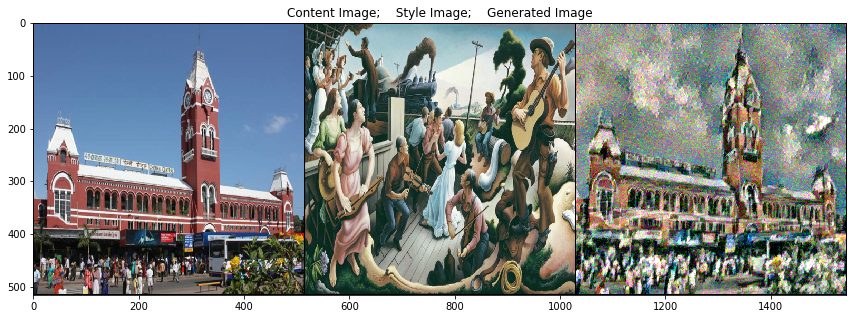

In [24]:
generate_image(content_images[0], style_images[3], display_plot=False)

Weight[content]:0.9900990099009901    Weight[style]:0.009900990099009901


Epoch:1    Loss:2.264160633087158    ContentLoss:0.6950390338897705    StyleLoss:159.1763153076172
Epoch:200    Loss:0.03216223418712616    ContentLoss:0.01489160768687725    StyleLoss:1.759224772453308



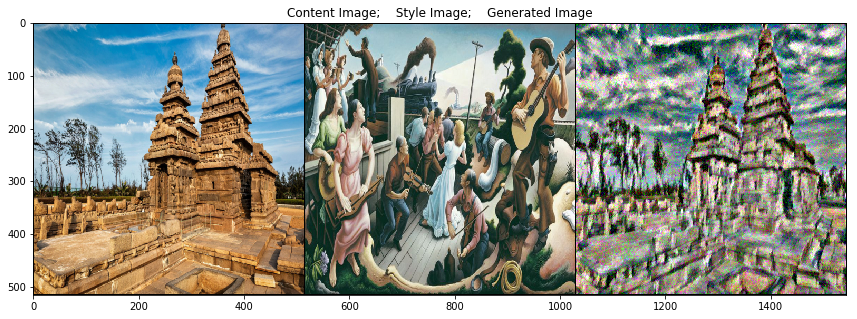

In [25]:
generate_image(content_images[1], style_images[3], display_plot=False)

Weight[content]:0.9900990099009901    Weight[style]:0.009900990099009901


Epoch:1    Loss:3.0200159549713135    ContentLoss:0.6923402547836304    StyleLoss:235.78758239746094
Epoch:200    Loss:0.027874890714883804    ContentLoss:0.011682851240038872    StyleLoss:1.6470788717269897



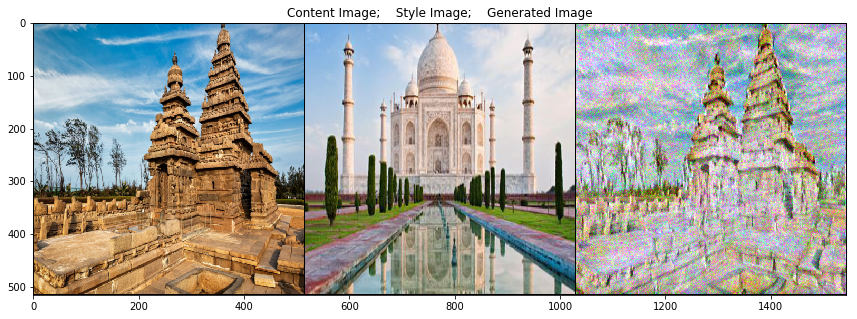

In [26]:
generate_image(content_images[1], style_images[4], display_plot=False)

Weight[content]:0.9900990099009901    Weight[style]:0.009900990099009901


Epoch:1    Loss:2.853527307510376    ContentLoss:0.45964643359184265    StyleLoss:242.2416229248047
Epoch:200    Loss:0.03670330345630646    ContentLoss:0.011376572772860527    StyleLoss:2.5693764686584473



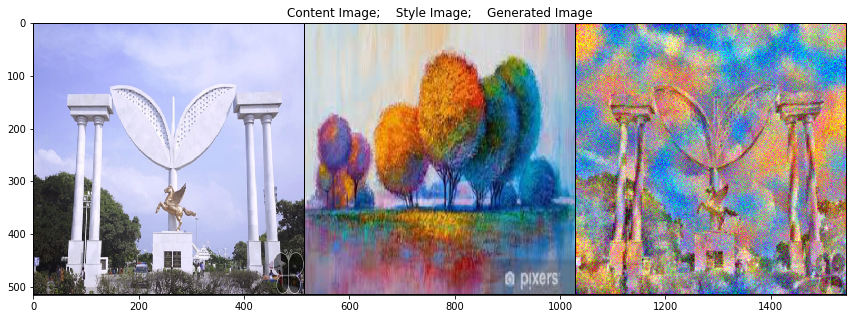

In [27]:
generate_image(content_images[2], style_images[0], display_plot=False)

Weight[content]:0.9900990099009901    Weight[style]:0.009900990099009901


Epoch:1    Loss:2.052316665649414    ContentLoss:0.4622795879840851    StyleLoss:161.0560302734375
Epoch:200    Loss:0.026963241398334503    ContentLoss:0.013184681534767151    StyleLoss:1.404819369316101



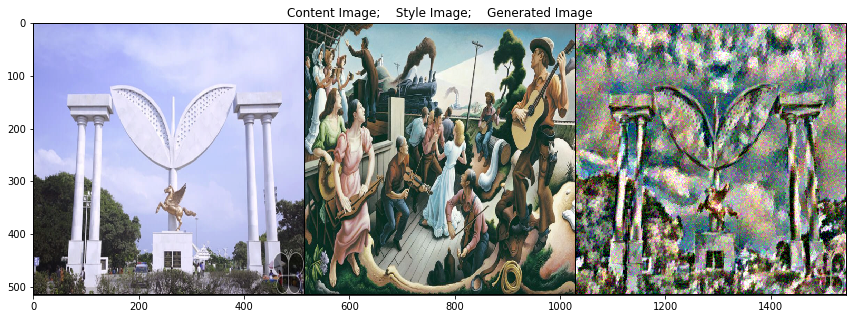

In [28]:
generate_image(content_images[2], style_images[3], display_plot=False)

Weight[content]:0.9900990099009901    Weight[style]:0.009900990099009901


Epoch:1    Loss:3.6138811111450195    ContentLoss:0.5118149518966675    StyleLoss:313.82049560546875
Epoch:200    Loss:0.03299771994352341    ContentLoss:0.018600139766931534    StyleLoss:1.4727556705474854



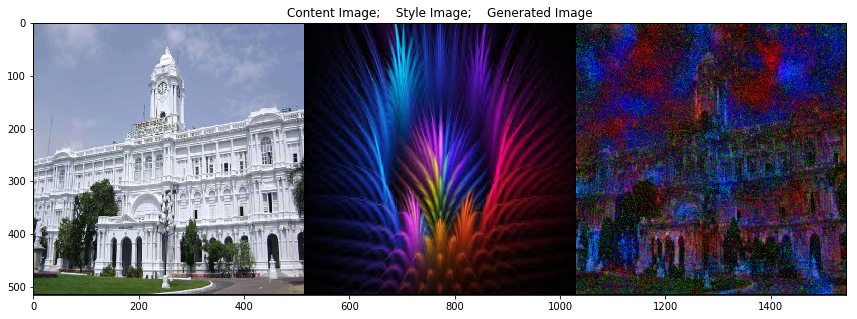

In [29]:
generate_image(content_images[3], style_images[1], display_plot=False)

Weight[content]:0.9900990099009901    Weight[style]:0.009900990099009901


Epoch:1    Loss:5.629245758056641    ContentLoss:0.5121845006942749    StyleLoss:517.3353881835938
Epoch:200    Loss:0.10898095369338989    ContentLoss:0.03838062658905983    StyleLoss:7.169013500213623



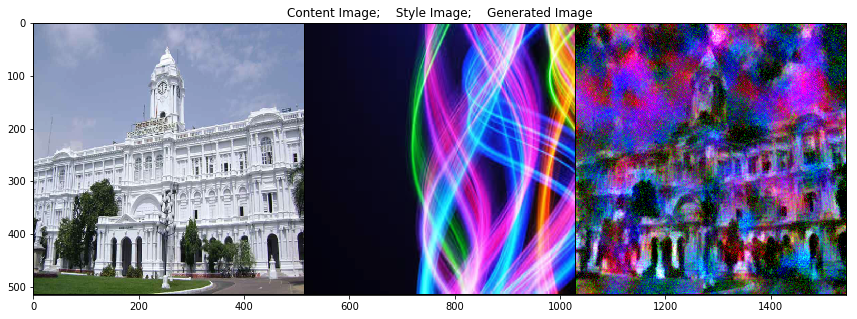

In [33]:
generate_image(content_images[3], style_images[2], display_plot=False)

Weight[content]:0.9900990099009901    Weight[style]:0.009900990099009901


Epoch:1    Loss:3.9798803329467773    ContentLoss:0.8579057455062866    StyleLoss:316.1773681640625
Epoch:200    Loss:0.035743456333875656    ContentLoss:0.020818103104829788    StyleLoss:1.5282788276672363



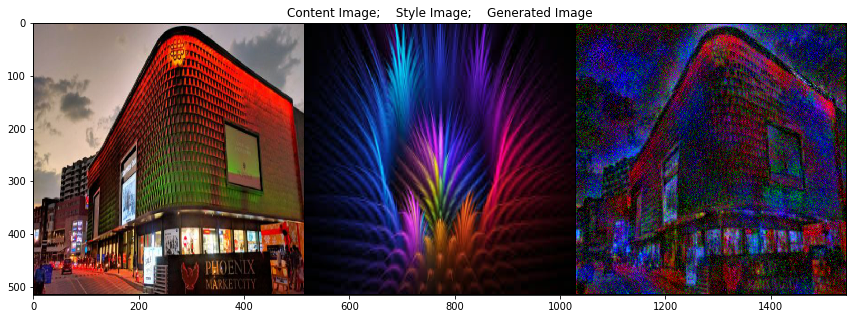

In [31]:
generate_image(content_images[4], style_images[0], display_plot=False)

Weight[content]:0.9900990099009901    Weight[style]:0.009900990099009901


Epoch:1    Loss:3.174968719482422    ContentLoss:0.8566262722015381    StyleLoss:235.0092315673828
Epoch:200    Loss:0.032936934381723404    ContentLoss:0.017658771947026253    StyleLoss:1.5607532262802124



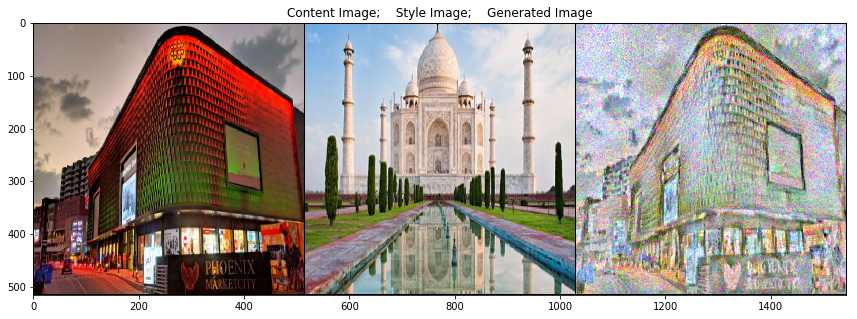

In [32]:
generate_image(content_images[4], style_images[4], display_plot=False)